### Nombre: Daniela Lucia Ramos Betin

In [1]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 43.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Succ


#*Pilotaje para la prueba de tamizaje para evaluación de lesiones dermatológicas como ayuda diagnostica a través de inteligencia artificial.*

**Cuál es el objetivo?**

Crear una herramienta en línea que pueda indicar a los médicos y técnicos de laboratorio los tres diagnósticos de mayor probabilidad para una determinada lesión de piel. Esto les ayudará a identificar rápidamente a los pacientes de alta prioridad y a acelerar su flujo de trabajo. La aplicación debería producir un resultado en menos de 3 segundos. Para asegurar la privacidad, las imágenes deben ser pre-procesadas y analizadas localmente y nunca ser subidas a un servidor externo.

In [2]:
!/opt/bin/nvidia-smi
!nvcc --version

#Se una nvidia T4 de Colab

Thu Jul 13 16:58:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from numpy.random import seed
seed(101)
import tensorflow
tensorflow.random.set_seed(101)


import pandas as pd
import numpy as np
#import keras
#from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


**LABELS**<br>

# Nota aqui tenemos las clases de lesiones dermatologicas.

Excerpts from the paper:<br>
> The HAM10000 Dataset: A Large Collection of Multi-Source Dermatoscopic Images of Common Pigmented Skin Lesions<br>
https://arxiv.org/abs/1803.10417



 **nv**<br>
 Los nevos melanocíticos son neoplasias benignas de los melanocitos y se presentan en una miríada de variantes, todas ellas incluidas en nuestra serie. Las variantes pueden diferir significativamente desde el punto de vista dermatoscópico.<br>
 *[6705 images]*

 **mel**<br>
 El melanoma es una neoplasia maligna derivada de los melanocitos que puede aparecer en diferentes variantes. Si se extirpa en una fase temprana, puede curarse mediante una simple escisión quirúrgica. Los melanomas pueden ser invasivos o no invasivos (in situ). Incluimos todas las variantes de melanoma, incluido el melanoma in situ, pero excluimos el melanoma no pigmentado, subungueal, ocular o de las mucosas.<br>*[1113 images]*


**bkl**<br>
 La "queratosis benigna" es una clase genérica que incluye la queratosis seborreica ("verruga senil"), el lentigo solar -que puede considerarse una variante plana de la queratosis seborreica- y la queratosis de tipo liquen plano (LPLK), que corresponde a una queratosis seborreica o a un lentigo solar con inflamación y regresión [22]. Los tres subgrupos pueden tener un aspecto dermatoscópico diferente, pero los hemos agrupado porque son similares desde el punto de vista biológico y a menudo se presentan bajo el mismo término genérico desde el punto de vista histopatológico. Desde el punto de vista dermatoscópico, las queratosis similares al liquen plano son especialmente difíciles porque pueden mostrar características morfológicas que imitan al melanoma [23] y a menudo se les practica una biopsia o una extirpación por motivos de diagnóstico. .<br>
*[1099 images]*

**bcc**<br>
El carcinoma basocelular es una variante común del cáncer de piel epitelial que rara vez hace metástasis, pero que crece destructivamente si no se trata. Aparece en diferentes variantes morfológicas (plano, nodular, pigmentado, quístico, etc.) [21], todas ellas incluidas en este conjunto.<br>
*[514 images]*

**akiec**<br>
Las queratosis actínicas (queratosis solares) y el carcinoma intraepitelial (enfermedad de Bowen) son variantes comunes no invasivas del carcinoma de células escamosas que pueden tratarse localmente sin cirugía. Algunos autores los consideran precursores de los carcinomas de células escamosas y no carci- nomas propiamente dichos. Sin embargo, hay acuerdo en que estas lesiones pueden evolucionar hacia un carcinoma de células escamosas invasivo, que normalmente no está pigmentado. Ambas neoplasias suelen mostrar escamas en la superficie y suelen carecer de pigmento. Las queratosis actínicas son más comunes en la cara y la enfermedad de Bowen es más común en otras zonas del cuerpo. Dado que ambos tipos son producidos por la luz ultravioleta, la piel circundante suele estar muy dañada por el sol, excepto en los casos de la enfermedad de Bowen, que están causados por la infección del virus del papiloma humano y no por la luz ultravioleta. Existen variantes pigmentadas para la enfermedad de Bowen [19] y para las queratosis actínicas [20]. Ambas se incluyen en este conjunto.<br>*[327 images]*


**vasc**<br>
Las lesiones vasculares de la piel en el conjunto de datos van desde los angiomas de cereza hasta los angioqueratomas [25] y los granulomas piogénicos [26]. Las hemorragias también se incluyen en esta categoría.<br>
*[142 images]*

**df**<br>
El dermatofibroma es una lesión cutánea benigna considerada como una proliferación benigna o una reacción inflamatoria a un traumatismo mínimo. Es de color marrón y a menudo muestra una zona central de fibrosis dermatoscópica [24].<br>*[115 images]*


<br>*[Total images = 10015]*

In [4]:
from google.colab import files
files.upload()
#before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
!mkdir data
!kaggle datasets download kmader/skin-cancer-mnist-ham10000 -p data

Saving kaggle.json to kaggle.json
100% 5.20G/5.20G [04:41<00:00, 23.1MB/s]
100% 5.20G/5.20G [04:41<00:00, 19.8MB/s]


In [5]:
# Unzip the whole zipfile into /content/data
!unzip -o data/skin-cancer-mnist-ham10000.zip -d data
# Quietly unzip the image files
#!unzip -o data/HAM10000_images_part_1.zip -d data
#!unzip -o data/HAM10000_images_part_2.zip -d data
# Tell me how many files I unzipped///
!echo files in /content/data: `ls data | wc -l`

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: data/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: data/ham10000_images

In [6]:
os.listdir('./data')

['hmnist_28_28_L.csv',
 'skin-cancer-mnist-ham10000.zip',
 'hmnist_8_8_L.csv',
 'ham10000_images_part_2',
 'hmnist_8_8_RGB.csv',
 'HAM10000_images_part_1',
 'HAM10000_metadata.csv',
 'ham10000_images_part_1',
 'hmnist_28_28_RGB.csv',
 'HAM10000_images_part_2']

### Crear la estructura de directorios

En estas carpetas almacenaremos las imágenes que posteriormente alimentarán los generadores de Keras.

In [7]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)

# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)



### Crear conjuntos de entrenamiento y validacion

In [8]:
df_data = pd.read_csv('./data/HAM10000_metadata.csv')

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Crear un conjunto de validacion estratificado

In [9]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [10]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):

    unique_list = list(df['lesion_id'])

    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [11]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [12]:
# now we filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

In [13]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.3, random_state=101, stratify=y)

df_val.shape

(1655, 8)

In [14]:
df_val['dx'].value_counts()

nv       1325
bkl       132
mel        69
bcc        53
akiec      45
vasc       19
df         12
Name: dx, dtype: int64

In [15]:
df_val.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
8208,HAM_0002324,ISIC_0025381,nv,histo,40.0,male,foot,no_duplicates
3044,HAM_0005093,ISIC_0030517,nv,follow_up,55.0,male,back,no_duplicates
4269,HAM_0007387,ISIC_0027119,nv,follow_up,75.0,female,abdomen,no_duplicates
5853,HAM_0002116,ISIC_0029407,nv,follow_up,40.0,male,upper extremity,no_duplicates
4792,HAM_0005912,ISIC_0027028,nv,follow_up,40.0,male,abdomen,no_duplicates


### Crear un conjunto de entrenamiento  que excluya las imágenes que están en el conjunto validacion

In [16]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])

    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)

# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

8360
1655


In [17]:
df_train['dx'].value_counts()

nv       5380
mel      1044
bkl       967
bcc       461
akiec     282
vasc      123
df        103
Name: dx, dtype: int64

In [18]:
df_val['dx'].value_counts()

nv       1325
bkl       132
mel        69
bcc        53
akiec      45
vasc       19
df         12
Name: dx, dtype: int64

### Transferencia de las imágenes a las carpetas

In [19]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [20]:
df_data.head()

,lesion_id,dx,dx_type,age,sex,localization,duplicates,train_or_val
image_id,,,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,has_duplicates,train
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,has_duplicates,train
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,has_duplicates,train
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,has_duplicates,train
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,has_duplicates,train


In [21]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('./data/HAM10000_images_part_1')
#folder_2 = os.listdir('../input/ham10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

# Transfer the train images

for image in train_list:

    fname = image + '.jpg'
    label = df_data.loc[image,'dx']

    if fname in folder_1:
        # source path to image
        src = os.path.join('./data/HAM10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
"""
    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

"""
# Transfer the val images

for image in val_list:

    fname = image + '.jpg'
    label = df_data.loc[image,'dx']

    if fname in folder_1:
        # source path to image
        src = os.path.join('./data/HAM10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
"""
    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
"""

"\n    if fname in folder_2:\n        # source path to image\n        src = os.path.join('../input/ham10000_images_part_2', fname)\n        # destination path to image\n        dst = os.path.join(val_dir, label, fname)\n        # copy the image from the source to the destination\n        shutil.copyfile(src, dst)\n"

In [22]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

2678
397
482
238
160
51
49


In [23]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

753
38
82
28
23
14
7


### Copiar las imágenes del train en aug_dir

In [24]:
# note that we are not augmenting class 'nv'
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:

    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders

    num_aug_images_wanted = 6000 # total number of images we want to have in each class

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)

    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 397 images belonging to 1 classes.
Found 482 images belonging to 1 classes.
Found 238 images belonging to 1 classes.
Found 160 images belonging to 1 classes.
Found 51 images belonging to 1 classes.
Found 49 images belonging to 1 classes.


In [25]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

2678
6005
5834
5762
4850
3110
5929


In [26]:
# Check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

753
38
82
28
23
14
7


### Visualizar 50 imágenes aumentadas

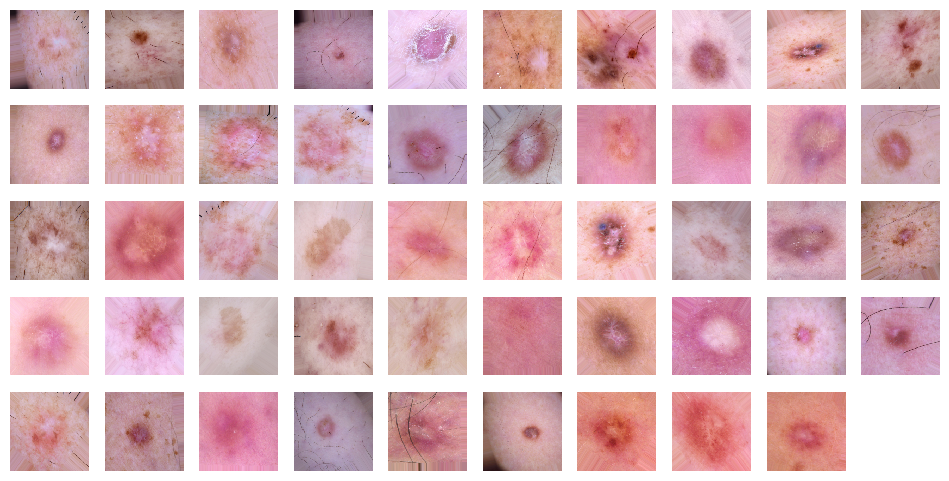

In [27]:
# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

plots(imgs, titles=None) # titles=labels will display the image labels

In [28]:
# End of Data Preparation
### ===================================================================================== ###
# Start of Model Building

### Configurar los generadores

In [187]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

In [188]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 15
val_batch_size = 15
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


In [189]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 34168 images belonging to 7 classes.
Found 945 images belonging to 7 classes.
Found 945 images belonging to 7 classes.


### Implementar y transformar el modelo tipo MobileNet

In [190]:
# create a copy of model

net_model = MobileNet()

In [191]:
net_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [192]:
type(net_model.layers)

list

In [193]:
# How many layers does MobileNet have?
len(net_model.layers)

91

In [194]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = net_model.layers[-2].output

# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.15)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=net_model.input, outputs=predictions)

In [195]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

In [196]:
# We need to choose how many layers we actually want to be trained.

for layer in model.layers[:-50]
    layer.trainable = False

### Entrenamiento del Modelo

In [197]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [198]:
model.compile(Adam(learning_rate=0.01), loss='categorical_crossentropy',
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [199]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [200]:
# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [201]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.00001)


callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps,
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)


Epoch 1/30


<ipython-input-201-649a607b18e1>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_batches, steps_per_epoch=train_steps,


558/558 [==============================] - ETA: 0s - loss: 3.0789 - categorical_accuracy: 0.4114 - top_2_accuracy: 0.6023 - top_3_accuracy: 0.7483


Epoch 1: val_top_3_accuracy improved from -inf to 0.92593, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


558/558 [==============================] - 58s 89ms/step - loss: 3.0789 - categorical_accuracy: 0.4114 - top_2_accuracy: 0.6023 - top_3_accuracy: 0.7483 - val_loss: 0.9124 - val_categorical_accuracy: 0.6984 - val_top_2_accuracy: 0.8582 - val_top_3_accuracy: 0.9259 - lr: 0.0100
Epoch 2/30
558/558 [==============================] - ETA: 0s - loss: 1.3897 - categorical_accuracy: 0.5617 - top_2_accuracy: 0.7578 - top_3_accuracy: 0.8896

558/558 [==============================] - 37s 67ms/step - loss: 1.3897 - categorical_accuracy: 0.5617 - top_2_accuracy: 0.7578 - top_3_accuracy: 0.8896 - lr: 0.0100
Epoch 3/30
558/558 [==============================] - ETA: 0s - loss: 1.2065 - categorical_accuracy: 0.6240 - top_2_accuracy: 0.8168 - top_3_accuracy: 0.9200

558/558 [==============================] - 35s 63ms/step - loss: 1.2065 - categorical_accuracy: 0.6240 - top_2_accuracy: 0.8168 - top_3_accuracy: 0.9200 - lr: 0.0100
Epoch 4/30
558/558 [==============================] - ETA: 0s - loss: 1.0793 - categorical_accuracy: 0.6683 - top_2_accuracy: 0.8452 - top_3_accuracy: 0.9417

558/558 [==============================] - 36s 65ms/step - loss: 1.0793 - categorical_accuracy: 0.6683 - top_2_accuracy: 0.8452 - top_3_accuracy: 0.9417 - lr: 0.0100
Epoch 5/30
558/558 [==============================] - ETA: 0s - loss: 1.0529 - categorical_accuracy: 0.6916 - top_2_accuracy: 0.8551 - top_3_accuracy: 0.9421

558/558 [==============================] - 36s 64ms/step - loss: 1.0529 - categorical_accuracy: 0.6916 - top_2_accuracy: 0.8551 - top_3_accuracy: 0.9421 - lr: 0.0100
Epoch 6/30
558/558 [==============================] - ETA: 0s - loss: 1.0214 - categorical_accuracy: 0.6976 - top_2_accuracy: 0.8654 - top_3_accuracy: 0.9472

558/558 [==============================] - 35s 63ms/step - loss: 1.0214 - categorical_accuracy: 0.6976 - top_2_accuracy: 0.8654 - top_3_accuracy: 0.9472 - lr: 0.0100
Epoch 7/30
558/558 [==============================] - ETA: 0s - loss: 0.9105 - categorical_accuracy: 0.7294 - top_2_accuracy: 0.8858 - top_3_accuracy: 0.9554

558/558 [==============================] - 36s 65ms/step - loss: 0.9105 - categorical_accuracy: 0.7294 - top_2_accuracy: 0.8858 - top_3_accuracy: 0.9554 - lr: 0.0100
Epoch 8/30
558/558 [==============================] - ETA: 0s - loss: 0.8909 - categorical_accuracy: 0.7472 - top_2_accuracy: 0.8950 - top_3_accuracy: 0.9578

558/558 [==============================] - 38s 67ms/step - loss: 0.8909 - categorical_accuracy: 0.7472 - top_2_accuracy: 0.8950 - top_3_accuracy: 0.9578 - lr: 0.0100
Epoch 9/30
558/558 [==============================] - ETA: 0s - loss: 0.9259 - categorical_accuracy: 0.7413 - top_2_accuracy: 0.8954 - top_3_accuracy: 0.9621

558/558 [==============================] - 37s 67ms/step - loss: 0.9259 - categorical_accuracy: 0.7413 - top_2_accuracy: 0.8954 - top_3_accuracy: 0.9621 - lr: 0.0100
Epoch 10/30
558/558 [==============================] - ETA: 0s - loss: 1.1955 - categorical_accuracy: 0.7106 - top_2_accuracy: 0.8649 - top_3_accuracy: 0.9363

558/558 [==============================] - 37s 65ms/step - loss: 1.1955 - categorical_accuracy: 0.7106 - top_2_accuracy: 0.8649 - top_3_accuracy: 0.9363 - lr: 0.0100
Epoch 11/30
558/558 [==============================] - ETA: 0s - loss: 0.9240 - categorical_accuracy: 0.7404 - top_2_accuracy: 0.8919 - top_3_accuracy: 0.9552

558/558 [==============================] - 37s 66ms/step - loss: 0.9240 - categorical_accuracy: 0.7404 - top_2_accuracy: 0.8919 - top_3_accuracy: 0.9552 - lr: 0.0100
Epoch 12/30
558/558 [==============================] - ETA: 0s - loss: 0.7448 - categorical_accuracy: 0.7900 - top_2_accuracy: 0.9191 - top_3_accuracy: 0.9692

558/558 [==============================] - 37s 66ms/step - loss: 0.7448 - categorical_accuracy: 0.7900 - top_2_accuracy: 0.9191 - top_3_accuracy: 0.9692 - lr: 0.0100
Epoch 13/30
558/558 [==============================] - ETA: 0s - loss: 0.7311 - categorical_accuracy: 0.7987 - top_2_accuracy: 0.9209 - top_3_accuracy: 0.9736

558/558 [==============================] - 36s 64ms/step - loss: 0.7311 - categorical_accuracy: 0.7987 - top_2_accuracy: 0.9209 - top_3_accuracy: 0.9736 - lr: 0.0100
Epoch 14/30
558/558 [==============================] - ETA: 0s - loss: 0.6573 - categorical_accuracy: 0.8196 - top_2_accuracy: 0.9392 - top_3_accuracy: 0.9800

558/558 [==============================] - 37s 65ms/step - loss: 0.6573 - categorical_accuracy: 0.8196 - top_2_accuracy: 0.9392 - top_3_accuracy: 0.9800 - lr: 0.0100
Epoch 15/30
558/558 [==============================] - ETA: 0s - loss: 0.6532 - categorical_accuracy: 0.8216 - top_2_accuracy: 0.9394 - top_3_accuracy: 0.9795

558/558 [==============================] - 36s 65ms/step - loss: 0.6532 - categorical_accuracy: 0.8216 - top_2_accuracy: 0.9394 - top_3_accuracy: 0.9795 - lr: 0.0100
Epoch 16/30
558/558 [==============================] - ETA: 0s - loss: 0.6500 - categorical_accuracy: 0.8204 - top_2_accuracy: 0.9402 - top_3_accuracy: 0.9810

558/558 [==============================] - 38s 68ms/step - loss: 0.6500 - categorical_accuracy: 0.8204 - top_2_accuracy: 0.9402 - top_3_accuracy: 0.9810 - lr: 0.0100
Epoch 17/30
558/558 [==============================] - ETA: 0s - loss: 0.6307 - categorical_accuracy: 0.8294 - top_2_accuracy: 0.9400 - top_3_accuracy: 0.9769

558/558 [==============================] - 37s 66ms/step - loss: 0.6307 - categorical_accuracy: 0.8294 - top_2_accuracy: 0.9400 - top_3_accuracy: 0.9769 - lr: 0.0100
Epoch 18/30
558/558 [==============================] - ETA: 0s - loss: 0.6047 - categorical_accuracy: 0.8411 - top_2_accuracy: 0.9478 - top_3_accuracy: 0.9805

558/558 [==============================] - 38s 68ms/step - loss: 0.6047 - categorical_accuracy: 0.8411 - top_2_accuracy: 0.9478 - top_3_accuracy: 0.9805 - lr: 0.0100
Epoch 19/30
558/558 [==============================] - ETA: 0s - loss: 0.6492 - categorical_accuracy: 0.8370 - top_2_accuracy: 0.9431 - top_3_accuracy: 0.9787

558/558 [==============================] - 36s 65ms/step - loss: 0.6492 - categorical_accuracy: 0.8370 - top_2_accuracy: 0.9431 - top_3_accuracy: 0.9787 - lr: 0.0100
Epoch 20/30
557/558 [============================>.] - ETA: 0s - loss: 0.5426 - categorical_accuracy: 0.8563 - top_2_accuracy: 0.9520 - top_3_accuracy: 0.9864

558/558 [==============================] - 37s 66ms/step - loss: 0.5439 - categorical_accuracy: 0.8560 - top_2_accuracy: 0.9520 - top_3_accuracy: 0.9864 - lr: 0.0100
Epoch 21/30
558/558 [==============================] - ETA: 0s - loss: 0.6345 - categorical_accuracy: 0.8466 - top_2_accuracy: 0.9434 - top_3_accuracy: 0.9799

558/558 [==============================] - 37s 66ms/step - loss: 0.6345 - categorical_accuracy: 0.8466 - top_2_accuracy: 0.9434 - top_3_accuracy: 0.9799 - lr: 0.0100
Epoch 22/30
558/558 [==============================] - ETA: 0s - loss: 0.5455 - categorical_accuracy: 0.8565 - top_2_accuracy: 0.9516 - top_3_accuracy: 0.9838

558/558 [==============================] - 36s 64ms/step - loss: 0.5455 - categorical_accuracy: 0.8565 - top_2_accuracy: 0.9516 - top_3_accuracy: 0.9838 - lr: 0.0100
Epoch 23/30
558/558 [==============================] - ETA: 0s - loss: 0.4571 - categorical_accuracy: 0.8779 - top_2_accuracy: 0.9612 - top_3_accuracy: 0.9891

558/558 [==============================] - 37s 66ms/step - loss: 0.4571 - categorical_accuracy: 0.8779 - top_2_accuracy: 0.9612 - top_3_accuracy: 0.9891 - lr: 0.0100
Epoch 24/30
558/558 [==============================] - ETA: 0s - loss: 0.5678 - categorical_accuracy: 0.8656 - top_2_accuracy: 0.9561 - top_3_accuracy: 0.9837

558/558 [==============================] - 37s 67ms/step - loss: 0.5678 - categorical_accuracy: 0.8656 - top_2_accuracy: 0.9561 - top_3_accuracy: 0.9837 - lr: 0.0100
Epoch 25/30
558/558 [==============================] - ETA: 0s - loss: 0.5870 - categorical_accuracy: 0.8601 - top_2_accuracy: 0.9493 - top_3_accuracy: 0.9812

558/558 [==============================] - 35s 63ms/step - loss: 0.5870 - categorical_accuracy: 0.8601 - top_2_accuracy: 0.9493 - top_3_accuracy: 0.9812 - lr: 0.0100
Epoch 26/30
558/558 [==============================] - ETA: 0s - loss: 0.5926 - categorical_accuracy: 0.8612 - top_2_accuracy: 0.9516 - top_3_accuracy: 0.9830

558/558 [==============================] - 36s 64ms/step - loss: 0.5926 - categorical_accuracy: 0.8612 - top_2_accuracy: 0.9516 - top_3_accuracy: 0.9830 - lr: 0.0100
Epoch 27/30
558/558 [==============================] - ETA: 0s - loss: 0.3889 - categorical_accuracy: 0.8970 - top_2_accuracy: 0.9693 - top_3_accuracy: 0.9908

558/558 [==============================] - 35s 63ms/step - loss: 0.3889 - categorical_accuracy: 0.8970 - top_2_accuracy: 0.9693 - top_3_accuracy: 0.9908 - lr: 0.0100
Epoch 28/30
558/558 [==============================] - ETA: 0s - loss: 0.4469 - categorical_accuracy: 0.8904 - top_2_accuracy: 0.9680 - top_3_accuracy: 0.9891

558/558 [==============================] - 35s 63ms/step - loss: 0.4469 - categorical_accuracy: 0.8904 - top_2_accuracy: 0.9680 - top_3_accuracy: 0.9891 - lr: 0.0100
Epoch 29/30
558/558 [==============================] - ETA: 0s - loss: 0.4215 - categorical_accuracy: 0.8967 - top_2_accuracy: 0.9710 - top_3_accuracy: 0.9913

558/558 [==============================] - 35s 62ms/step - loss: 0.4215 - categorical_accuracy: 0.8967 - top_2_accuracy: 0.9710 - top_3_accuracy: 0.9913 - lr: 0.0100
Epoch 30/30
558/558 [==============================] - ETA: 0s - loss: 0.4914 - categorical_accuracy: 0.8866 - top_2_accuracy: 0.9643 - top_3_accuracy: 0.9866

558/558 [==============================] - 36s 64ms/step - loss: 0.4914 - categorical_accuracy: 0.8866 - top_2_accuracy: 0.9643 - top_3_accuracy: 0.9866 - lr: 0.0100


In [202]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Evaluar el modelo utilizando el conjunto de valores de validación

In [203]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [204]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches,
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

<ipython-input-204-1650d8f783d0>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_batches,


val_loss: 0.8302396535873413
val_cat_acc: 0.841269850730896
val_top_2_acc: 0.929100513458252
val_top_3_acc: 0.9661375880241394


In [205]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches,
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

<ipython-input-205-fe056fefdc1b>:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_batches,


val_loss: 0.9123552441596985
val_cat_acc: 0.6984127163887024
val_top_2_acc: 0.8582010865211487
val_top_3_acc: 0.9259259104728699


### Trazar las curvas de entrenamiento

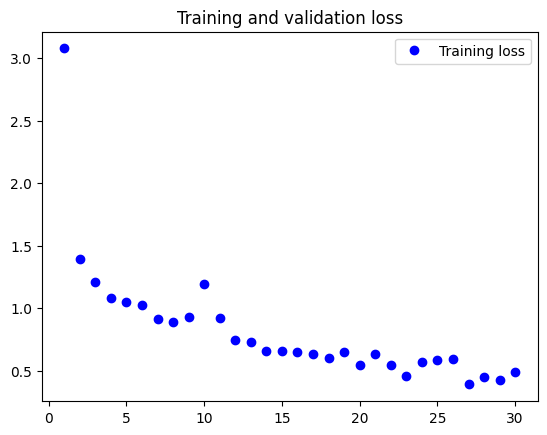

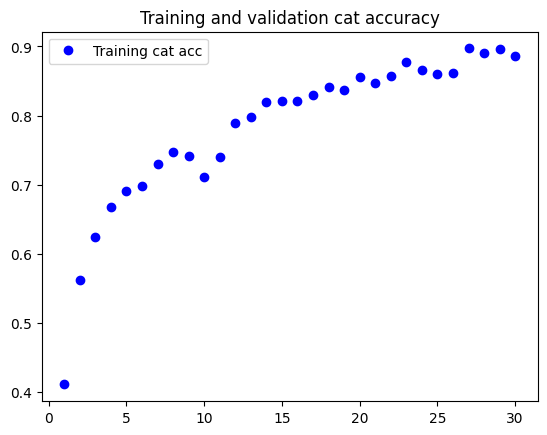

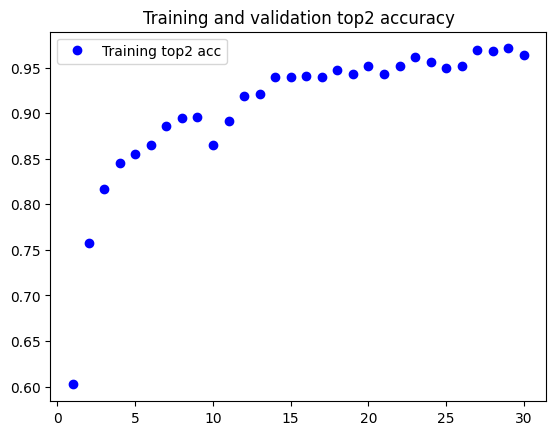

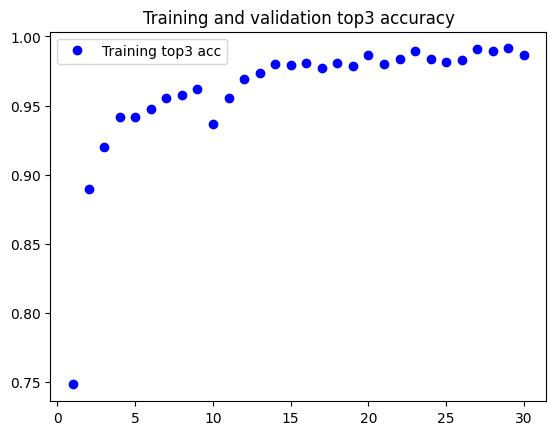

In [208]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
#plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
#plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
#plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

In [209]:
val_loss = history.history['val_loss']
val_loss

[0.9123558402061462]

### Creando la matriz de confusión

In [210]:
# Get the labels of the test images.
# Note that cats and dogs are in seperate folders therefore
# the code below can get the labels depending on the folder the image is in.

test_labels = test_batches.classes

In [211]:
# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [212]:
# Print the label associated with each class
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [213]:
# make a prediction
predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

<ipython-input-213-9c0b47a7196d>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)


 945/1655 [================>.............] - ETA: 11s

1655/1655 [==============================] - 16s 9ms/step


In [214]:
predictions.shape

(945, 7)

In [215]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [216]:
test_labels.shape

(945,)

In [217]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [218]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[  0   8   1   2  12   0   0]
 [  0  21   0   1   1   5   0]
 [  0  11   2   4  46  19   0]
 [  0   0   0   1   0   6   0]
 [  0   1   0   0  35   1   1]
 [  0  19   0  19 111 594  10]
 [  0   1   0   0   0   6   7]]


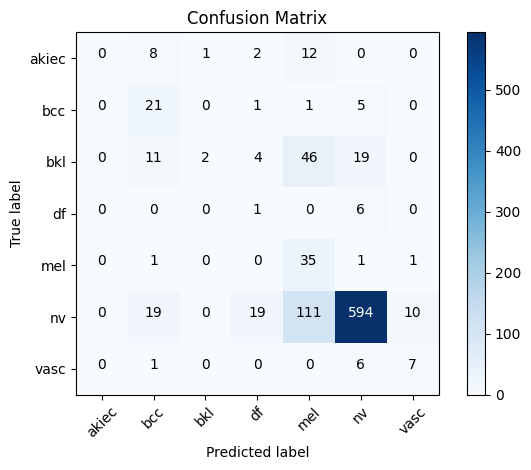

In [219]:
# Define the labels of the class indices. These need to match the
# order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
# End of Model Building
### ===================================================================================== ###
# Convert the Model from Keras to Tensorflow.js

In [220]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [221]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        23
         bcc       0.34      0.75      0.47        28
         bkl       0.67      0.02      0.05        82
          df       0.04      0.14      0.06         7
         mel       0.17      0.92      0.29        38
          nv       0.94      0.79      0.86       753
        vasc       0.39      0.50      0.44        14

    accuracy                           0.70       945
   macro avg       0.36      0.45      0.31       945
weighted avg       0.83      0.70      0.72       945



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall = Given a class, will the classifier be able to detect it?

Precision = Given a class prediction from a classifier, how likely is it to be correct?

F1 Score = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.

### Convert the model from Keras to Tensorflowjs
The conversion code below no longer works in kaggle kernels. I've left it in for reference.

In order to convert this model the workaround is as follows:<br>
1. Recreate the model using native Keras.<br>
2. Use the command line conversion process to convert the model from Keras to Tensorflowjs.<br>
Here's how to do that: https://www.youtube.com/watch?v=Kc2_x6pBYGE

The above steps can be done in a kaggle kernel quite easily. Tensorflowjs is still fairly new so these type of bugs are not unusual.

In [222]:
from tensorflow.keras.models import load_model
import tensorflowjs as tfjs

# Crear un directorio para almacenar los archivos del modelo
os.makedirs('tfjs_dir', exist_ok=True)

# Guardar el modelo en formato h5
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [223]:
!mkdir model
!tensorflowjs_converter --input_format keras model.h5 model/

2023-07-13 19:25:01.312466: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [224]:
# Convertir el modelo a formato TensorFlow.js
tfjs.converters.save_keras_model(model, 'tfjs_dir')

In [225]:
!zip -r model.zip model

from google.colab import files
files.download('model.zip')

  adding: model/ (stored 0%)
  adding: model/group1-shard1of5.bin (deflated 7%)
  adding: model/group1-shard2of5.bin (deflated 7%)
  adding: model/model.json (deflated 95%)
  adding: model/group1-shard4of5.bin (deflated 7%)
  adding: model/group1-shard5of5.bin (deflated 7%)
  adding: model/group1-shard3of5.bin (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [226]:
# check the the directory containing the model is available
!ls

base_dir  data	kaggle.json  model  model.h5  model.zip  sample_data  tfjs_dir


### Resources

These are some resources that I used:

1. Excellent tutorial series by deeplizard on how to use Mobilenet with Tensorflow.js<br>
https://www.youtube.com/watch?v=HEQDRWMK6yY

2. Tutorial by Minsuk Heo on Accuracy, Precision and F1 Score<br>
https://www.youtube.com/watch?v=HBi-P5j0Kec

3. Tutorial by Data School on how to evaluate a classifier<br>
https://www.youtube.com/watch?v=85dtiMz9tSo

3. Tensorflow.js gallery of projects<br>
https://github.com/tensorflow/tfjs/blob/master/GALLERY.md

